# Fáza 1 - Prieskumná analýza

## EDA vizualizácia

Než začneme so samotnou analýzou a jej vizualizáciou, najskôr je potrebné naimportovať si nejaké knižnice.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
from datetime import datetime
from scipy.stats import levene
from scipy.stats import mannwhitneyu

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Analýza súborov

- Pracujeme s tromi __.csv__  súbormi, kde jednotlivé atribúty sú oddelené __tabulátormi__. Súbory máme udržované v nasledovnej štruktúre:

  - EDA.ipynb
  - resources
    * user.csv
    * product.csv
    * session.csv
- Daná štruktúra predstavuje __hierarchické usporiadanie__ súborov v našom projektovom adresári. Teraz si môžeme vytvoriť konštantné premenné
  predstavujúce relatívne cesty pre neskoršiu manipuláciu so súbormi:

In [3]:
PRODUCT_FILE_PATH = "resources/product.csv"
USER_FILE_PATH = "resources/user.csv"
SESSION_FILE_PATH = "resources/session.csv"

#### Vzťahy medzi súbormi
- Máme celkovo 3 súbory. Keď sa pozrieme na vzťah medzi jedným používateľom a produktom, tak možno usúdiť, že ide o vzťah typu
  __many-to-many__, nakoľko jeden používateľ môže (ne)kúpiť 0 a viac produktov a jeden produkt môže byť viazaný s viacerými používateľmi, ktorí si ho
  nekúpili. Je preto nutné vytvoriť spojovací súbor, ktorý bude obsahovať záznamy s referenciami na užívateľov aj na produkty. To predstavuje práve súbor session.csv, ktorý okrem product_ean a user_id obsahuje aj údaje o interakcii užívateľa s konkrétnym produktom.

### Analýza záznamov

- Jednotlivé záznamy sú uchovávané v .csv súboroch a oddelovač atribútov je tabulátor. Jeden riadok bude teda predstavovať jeden záznam a hodnoty oddelené tabulátorom budú hodnoty pre konkrétny atribút (stĺpec). Pre zistenie počtu záznamov potrebujeme najskôr každý súbor otvoriť a získať tak aj premennú pre dataset:

In [4]:
df_pro = pd.read_csv(PRODUCT_FILE_PATH, delimiter='\t')
df_usr = pd.read_csv(USER_FILE_PATH, delimiter='\t')
df_sess = pd.read_csv(SESSION_FILE_PATH, delimiter='\t')

- Teraz možno jednoducho použiť funkciu len() a vypísať výsledky:

In [9]:
df_pro_len = len(df_pro)
df_usr_len = len(df_usr)
df_sess_len = len(df_sess)

print(f'Počet produktov: {df_pro_len}')
print(f'Počet používateľov: {df_usr_len}')
print(f'Počet interakcií: {df_sess_len}')

Počet produktov: 14967
Počet používateľov: 2533
Počet interakcií: 11099


- Na zistenie počtu a typov atribútov môžeme využiť nasledovné funkcie:

In [13]:
print(f'Number of attributes for product.csv: {df_pro.shape[1]}')
print(f'Number of attributes for user.csv: {df_usr.shape[1]}')
print(f'Number of attributes for session.csv: {df_sess.shape[1]}')
      
df_pro.dtypes

Number of attributes for product.csv: 4
Number of attributes for user.csv: 11
Number of attributes for session.csv: 25


location       object
product_ean     int64
store_name     object
code           object
dtype: object

In [14]:
df_usr.dtypes

address             object
name                object
race                object
registration        object
username            object
current_location    object
sex                 object
birthdate           object
mail                object
user_id              int64
job                 object
dtype: object

In [15]:
df_sess.dtypes

browser_name                       object
pct_input                         float64
wild_mouse_duration               float64
pct_scroll_move_duration          float64
pct_wild_mouse                    float64
session_start                      object
pct_doubleclick                   float64
pct_rage_click                    float64
pct_click                         float64
page_activity_duration            float64
product_ean                         int64
pct_scrandom                      float64
mouse_move_total_rel_distance     float64
pct_click_product_info            float64
scroll_move_total_rel_distance    float64
session_id                          int64
pct_mouse_click                   float64
pct_scroll_move                   float64
user_id                             int64
screen_width                       object
session_duration                  float64
screen_height                      object
total_load_time                   float64
ack                               

- Sem ešte doplniť nejakú analýzu typov dát

### Analýza atribútov
- Teraz analyzujeme niektoré významné atribúty a ukážeme ich distribúcie a iné deskriptívne štatistiky.


#### Analýza pohlaví
- Pri analýze distribúcii jednotlivých pohlaví sme museli vylúčiť nešpecifikované hodnoty pri atribúte pohlavie.

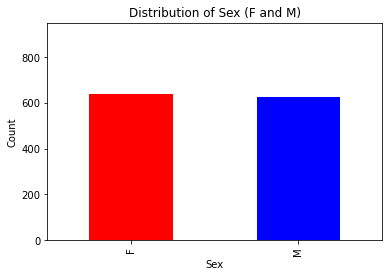

count     1267
unique       2
top          F
freq       640
Name: sex, dtype: object

In [17]:
sex_df = df_usr['sex'].dropna(how='any')
sex_counts = sex_df.value_counts()

sex_counts.plot(kind='bar', color=['red', 'blue'], alpha=1)
plt.ylim(0, 950)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Sex (F and M)')
plt.show()

sex_df.describe()


- Z poskytnutých deskriptívnych štatistík vidno celkový počet elementov v datasete, a aj to, že sa zrejme pôjde o kategórie, nakoľko unikátne hodnoty sú len 2. Aj graf, aj štatistika ukazuje, že medzi používateľmi prevažujú ženy. 

#### Analýza top 30 lokácií produktov
- V tejto časti analyzujeme distribúcie krajín, ktoré vyrabájú dané produkty. Pre prehľadnosť sme sa rozhodli obmedziť výsledky len na top 30 krajín.

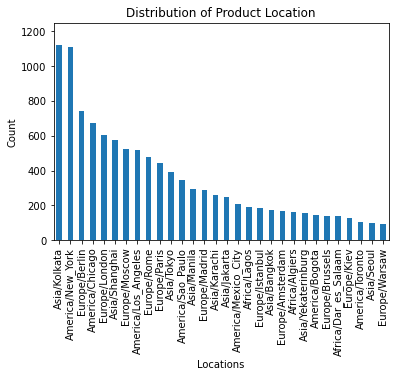

count            14967
unique             184
top       Asia/Kolkata
freq              1121
Name: location, dtype: object

In [7]:
loc_df = df_pro['location'].dropna(how='any')
loc_counts = loc_df.value_counts().head(30)

loc_counts.plot(kind='bar', alpha=1)
plt.ylim(0, 1250)
plt.xlabel('Locations')
plt.ylabel('Count')
plt.title('Distribution of Product Location')
plt.show()

loc_df.describe()

- Z štatistík možno vidieť opäť celkový počet produktov pochádzajúcich zo všetkých krajín aj počet unikátnych hodnôt, čo v tomto prípade predstavuje počet krajín. Opäť možno aj s grafu vidieť, že najväčším nákupným mestom je Kolkata.

#### Analýza distribúcie webových prehliadačov
- Pomocou Pie Chartu v tejto časti analyzujeme distribúciu webových prehliadačov používaných počas sedení. Nešpecifikované prípady sme z analýzy vypustili.

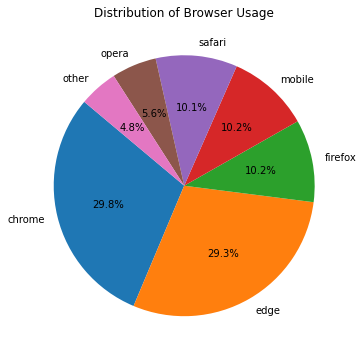

count      11099
unique         7
top       chrome
freq        3304
Name: browser_name, dtype: object

In [32]:
brow_df = df_sess['browser_name'].dropna(how="any")

brow_counts = brow_df.value_counts().head(25)
brow_counts

plt.pie(brow_counts, labels=brow_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')


plt.title('Distribution of Browser Usage')
plt.show()

brow_df.describe()

- V štatistike vidno počet zaznamenaných sedení. Počas nich bolo použitých celkovo 7 webových prehliadačov, z ktorých boli najpopulárnejší chrome a edge, ktoré tvoria takmer 60 percent celkovej používanosti.

#### Analýza distribúcie veku
- V tejto časti skúmame distribúciu veku jednotlivých používateľov. Nakoľko máme prístupnú iba hodnotu 'birthdate', museli sme tento atribút najskôr prekonvertovať na požadovaný formát a následne odčítať od súčasného času. Na záver sme výslednú hodnotu museli ešte premeniť z dní na roky.
- Nešpecifikované prípady sme ako vždy nebrali do úvahy.


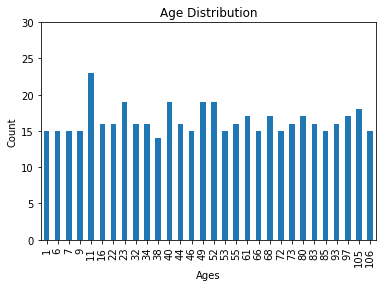

count    1393.000000
mean       56.946877
std        33.089547
min         0.000000
25%        29.000000
50%        56.000000
75%        84.000000
max       116.000000
Name: age, dtype: float64

In [75]:
df_ages = pd.DataFrame({'user_id' : df_usr['user_id'],
                    'age': (datetime.now() - pd.to_datetime(df_usr['birthdate'].dropna(how="any"), format='%Y-%m-%d'))
                    .apply(lambda x: x.days // 365) }).dropna(how="any")

#df2
age_counts = df_ages['age'].value_counts().head(30).sort_index()
age_counts.index = age_counts.index.astype(int)
age_counts

age_counts.plot(kind='bar', alpha=1)
plt.ylim(0, 30)
plt.xlabel('Ages')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

df_ages['age'].describe()

- Z dostupnej štatistiky možno vidieť, že priemerný vek užívateľa na pohybuje na úrovni 56 rokov. Od tejto hodnoty sú všetky hodnoty odchýlené v hodnote 33. Najmenší vek užívateľa nie je ani rok a najstarší vek 116 rokov. Ešte možno pozorovať, aké percento užívateľov je mladších ako uvedené roky, napríklad 1/4 užívateľov je starších ako 84 rokov.

#### Analýza aktivity užívateľov na stránkach
- V tejto časti skúmame aktivitu používateľov na stránkach z hľadiska veku. Využívame pritom predchádzajúci dataset, ktorý obsahuje user_id a vypočítaný vek na základe dátumu narodenia.

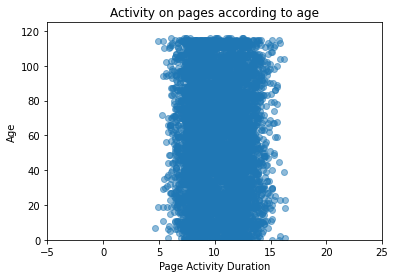

count    6030.000000
mean       10.226932
std         2.119439
min         4.651370
25%         8.470945
50%        10.043925
75%        11.968680
max        16.280780
Name: page_activity_duration, dtype: float64

In [46]:
#user_age_subset = original_df[['user_id', 'age']]
page_time_subset = df_sess[['user_id', 'page_activity_duration']].dropna(how="any")
merged_df = df_ages.merge(page_time_subset, on='user_id', how='inner')

plt.scatter(merged_df['page_activity_duration'], merged_df['age'], alpha=0.5)
plt.xlabel('Page Activity Duration')
plt.ylabel('Age')
plt.title('Activity on pages according to age')

plt.xlim(-5, 25)
plt.ylim(0, 125)

plt.show()

merged_df['page_activity_duration'].describe()

- Z uvedenej štatistiky vidno počet sedení, ktorých užívatelia mali špecifikované miesto narodenia, ID a bola nameraný strávený čas na stránke. Priemer času stráveného na stránke bol niečo cez 10 minút. Hodnoty sú od tejto hodnoty odchýlené v priemere o 2 minúty. Minimálny nameraný čas na stránke bol okolo 4 aj pol minúty, najväčší až niečo cez 16. Ďalej možno napríklad vidieť, že 50 percent užívateľov trávi na stránke menej ako 10 minút času.

#### Analýza dĺžky pohybu myši užívateľov
- V tejto časti sa venujeme analýze dĺžky pohybu myši pri jednotlivých užívateľoch.

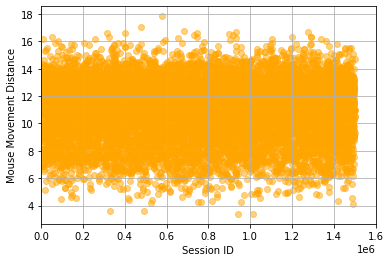

count    11088.000000
mean        10.977960
std          2.125200
min          3.388300
25%          9.621833
50%         11.281175
75%         12.496550
max         17.831800
Name: mouse_move_total_rel_distance, dtype: float64

In [8]:
mouse_mv_df = df_sess[['mouse_move_total_rel_distance', 'session_id']].dropna(how="any")

mouse_mv_df

plt.scatter(mouse_mv_df['session_id'], mouse_mv_df['mouse_move_total_rel_distance'], alpha=0.5, color='Orange')
plt.xlabel('Session ID')
plt.ylabel('Mouse Movement Distance')
#plt.title('Activity on pages according to age')

#plt.xlim(-5, 25)
#plt.ylim(0, 1)
plt.xlim(0, 1600000)
plt.grid(True)
plt.show()
# Display the plot
#plt.show()

mouse_mv_df['mouse_move_total_rel_distance'].describe()


#### Analýza distribúcie výsledkov sedení



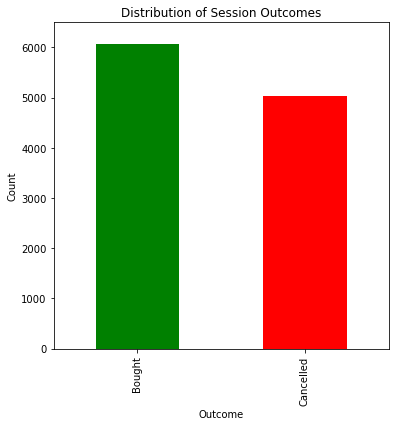

count    11099.000000
mean         0.547347
std          0.497776
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: ack, dtype: float64

In [111]:
ack_df = df_sess['ack'].dropna(how='any')
ack_counts = ack_df.value_counts()

plt.figure(figsize=(6, 6))  
ack_counts.plot(kind='bar', color=['green', 'red'], alpha=1)

plt.xticks(range(len(['Bought', 'Cancelled'])), ['Bought', 'Cancelled'])
plt.ylim(0, 6500)
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Distribution of Session Outcomes')

plt.show()

ack_df.describe()

#### Analýza kompletného času načítavania počas sedení

count    11099.000000
mean         4.009680
std          2.848359
min          0.029800
25%          1.944085
50%          3.355530
75%          5.361660
max         21.149270
Name: total_load_time, dtype: float64

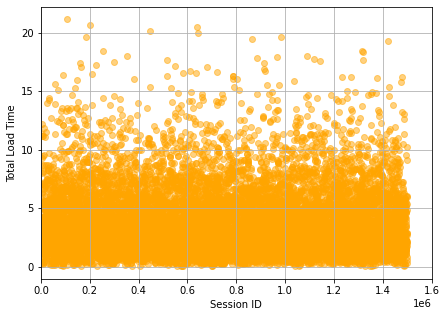

In [115]:
# Assuming 'df_sess' is your DataFrame
load_time_df = df_sess[['total_load_time', 'session_id']].dropna(how="any")

plt.figure(figsize=(7, 5))
# Plot the scatter plot and cumulative mean
plt.scatter(load_time_df['session_id'], load_time_df['total_load_time'], alpha=0.5, color='Orange')
plt.xlabel('Session ID')
plt.ylabel('Total Load Time')
plt.xlim(0, 1600000)
plt.grid(True)

# Display the descriptive statistics
load_time_df['total_load_time'].describe()

#### Analýza počtu sedení za mesiac v roku 2022

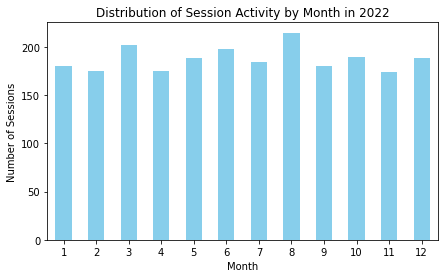

In [95]:
# Assuming 'df_sess' is your DataFrame
df_sess['session_start'] = pd.to_datetime(df_sess['session_start'], format='%Y-%m-%d %H:%M:%S')


df_sess_2021_c = pd.DataFrame({
    "start": df_sess[df_sess['session_start'].dt.year == 2022]['session_start'].dt.month
})
                              
df_sess_2021_c
#Group by month and count the number of sessions
session_count_by_month = df_sess_2021_c.groupby('start').size()
session_count_by_month


# Create a plot
plt.figure(figsize=(7, 4))
session_count_by_month.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Activity by Month in 2022')
plt.xticks(rotation=0)
plt.show()

#### Analýza rás užívateľov

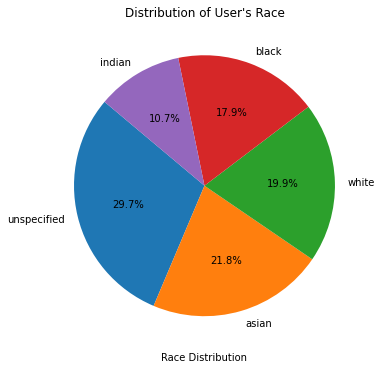

count             760
unique              5
top       unspecified
freq              226
Name: race, dtype: object

In [89]:
race_df = df_usr['race'].dropna(how='any')
race_counts = race_df.value_counts()

plt.figure(figsize=(6, 6))  
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140)

plt.xlabel('Race Distribution')
plt.title("Distribution of User's Race")

plt.show()

race_df.describe()

### Párová analýza
- V tejto časti skúmame závislosti medzi rôznymi dvojicami dát. Pri identifikácii korelácie pre lepšiu prehľadnosť uvádzame 3 typy koreláčných koeficientov:

  a) __Pearson__
  
  b) __Spearman__
  
  c) __Kendall__

- Výslednú lineárnu závislosť následne zobrazujeme pomocou grafu.

#### Závislosti medzi vekom a aktivitou na stránkach

- Na začiatok využijeme predchádzajúci spojený dataset a zistíme koreláciu medzi vekom a ktivitou na stránkach. Budeme počítať dva typy korelácií, jednu od Pearsona a druhú od Spearmana.

In [26]:
# Calculate the Pearson correlation coefficient
pearson_corr = merged_df['age'].corr(merged_df['page_activity_duration'], method='pearson')

# Calculate the Spearman rank correlation coefficient
spearman_corr = merged_df['age'].corr(merged_df['page_activity_duration'], method='spearman')

print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

covariance = np.cov(merged_df['page_activity_duration'], merged_df['age'])[0, 1]
print(f'Covariance: {covariance}')

Pearson Correlation: -0.012726597035140721
Spearman Correlation: -0.013286159354254017
Covariance: -0.9017620919354137


- Z výsledkov možno pozorovať, že korelácia je v oboch prípadoch takmer nulová. To znamená, že aktivita nema tendenciu ani rásť s ratúcim vekom, ani klesať s klesajúcím. Nemá tendenciu ani klesať s rastúcim ani rásť s klesajúcim. Už z predchádzajúceho grafu vidieť, že hodnota aktivity sa drží medzi 10 až 11.Skúsme vypočítať štandardnú odchýlku:

In [27]:
print(f"Standard dev: {merged_df['page_activity_duration'].std()}")


Standard dev: 2.119438982897867


- Z grafu takisto vyplýva, že vek by aj mohol mať normálne rozdelenie hodnôt. Je, ale pravda, že nemá skoro žiadne chvosty. Môžme preto preskúmať ešte ďalšie vlastnosti na overenie vlastností normálneho rozdelenia.
#### Skewness a Kurtosis

In [28]:
skew(merged_df['age'])

0.04730545143263757

In [29]:
merged_df['age'].kurtosis()

-1.1863141081331903

- Z daných hodnôt vyplýva, že rozdelenie je celkom pekne rozdistribuované na ľavú aj pravú stranu, je iba mierne naklonené na ľavú stranu. Avšak hodnota
pre druhú vlastnosť jasne ukazuje, že rozdelenie má nižší vrch a menšie chvosty ako normálne rozdelenie.

#### Korelácia medzi pohybom myši a celkovou vzdialenosťou

- V tejto časti analyzujeme párovú závislosť medzi parametrami __pct_mouse_move__ a __mouse_move_total_rel_distance__. Snažíme sa zistiť, či tieto dve parametre korelujú.
- Pre porovnanie vykonávame

3


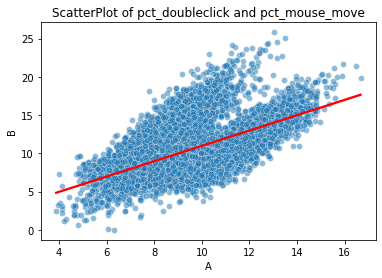

p-value: 0.5922055589951355




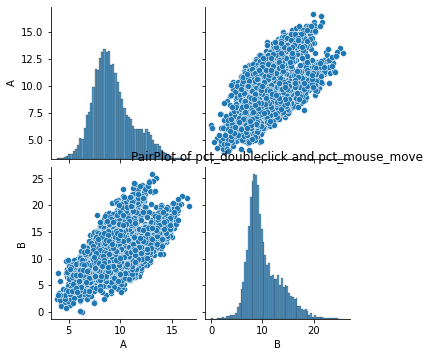

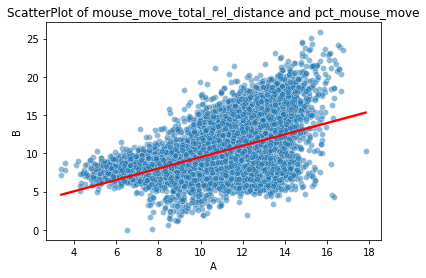

p-value: 0.485381430378118




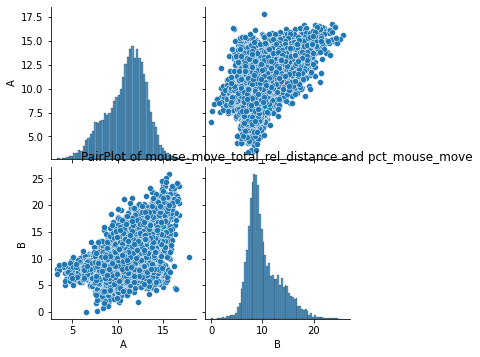

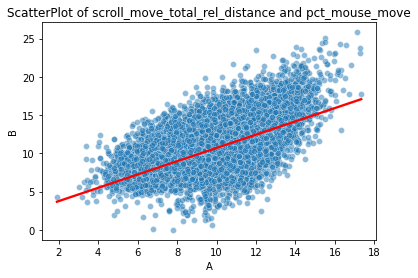

p-value: 0.5816662133668252




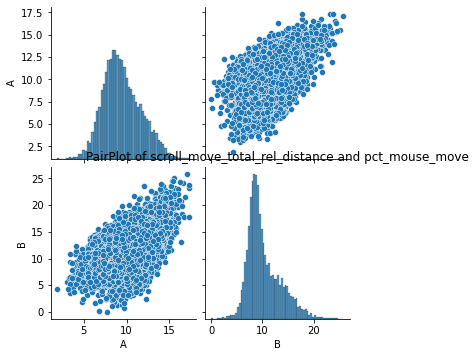

In [50]:
def find_homog_var(df, number=3):
    COLUMN_COUNT = df.shape[1]
    pairs = []
    
    for i in range (0, COLUMN_COUNT):
        col_A_name = df.columns[i]
        col_A = df.iloc[:, i]
        
        for g in range (i + 1, COLUMN_COUNT):
            col_B_name = df.columns[g]
            col_B = df.iloc[:, g]
            
            # Check if the data type of both columns is numeric
            if col_A.dtype in [int, float] and col_B.dtype in [int, float]:
                new_df = pd.DataFrame({'A': col_A, 'B': col_B}).dropna(how="any")
                
                # Perform the Levene test if data types are valid
                #statistic, p_value = levene(new_df['A'], new_df['B'])

                    # Calculate the Pearson correlation coefficient
                pearson_corr = new_df['A'].corr(new_df['B'], method='pearson')
                # Calculate the Spearman rank correlation coefficient
                spearman_corr = new_df['A'].corr(new_df['B'], method='spearman')
                kendall_corr = new_df['A'].corr(new_df['B'], method='kendall')
                
                if pearson_corr > 0.05:
                    #print(f"Variances between columns {col_A_name} and {col_B_name} are equal (failed to the null hypothesis)")
                    #print(f'p: {p_value}')

                    #This represents a dictionary containing both attributes and their p-value
                    new_el = {
                        'A': col_A_name,
                        'B': col_B_name,
                        'p_value': pearson_corr
                    }
                    
                    if len(pairs) < number:
                        pairs.append(new_el)
                    else:
                        for el in pairs:
                            if el['p_value'] < pearson_corr:
                                pairs.append(new_el)

                                pairs.remove(el)
                                break
    
    return pairs
    
list = find_homog_var(df_sess)

print(len(list))

for el in list:
    new_df = pd.DataFrame({'A': df_sess[el['A']], 'B': df_sess[el['B']]}).dropna(how="any")

    # Create a scatter plot
    sns.scatterplot(x='A', y='B', data=new_df, alpha=0.5)
    #plt.title('Scatter Plot with Pearson Correlation Line')
    plt.title(f"ScatterPlot of {el['A']} and {el['B']}")

    # Add the Pearson correlation line
    sns.regplot(x='A', y='B', data=new_df, scatter=False, color='red')
    
    #plt.text(0.1, 4000, f"Pearson Correlation: {el['p_value']}", color='red', fontsize=12)
    
    plt.show()
    
    print(f"p-value: {el['p_value']}")
    print('\n')
    
    sns.pairplot(new_df)
    plt.title(f"PairPlot of {el['A']} and {el['B']}")
    
    plt.show()


#### Hľadanie homogénnych rozptylov medzi atribútmi pomocou Levene testu

- 

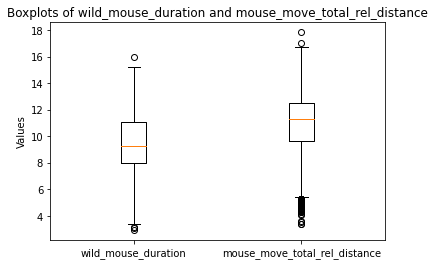

p-value: 0.8158937209740952




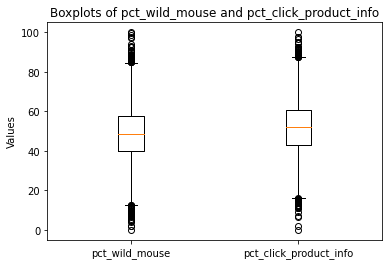

p-value: 0.7736268443392054




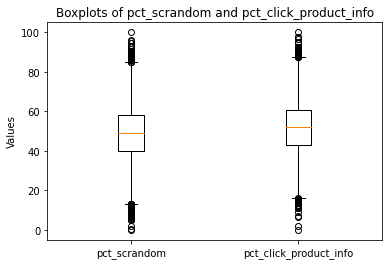

p-value: 0.7857905701612693




In [16]:
new_df = pd.DataFrame({'mouse_move': df_sess['pct_click'],
                     'mouse_move_dist': df_sess['pct_doubleclick']}).dropna(how="any")

# This function tests all combinations of attributes in the dataframe and performs Levene test on them
# and returns the top i pairs with the highest level of homogenous variance
def find_homog_var(df, number=3):
    COLUMN_COUNT = df.shape[1]
    pairs = []
    
    for i in range (0, COLUMN_COUNT):
        col_A_name = df.columns[i]
        col_A = df.iloc[:, i]
        
        for g in range (i + 1, COLUMN_COUNT):
            col_B_name = df.columns[g]
            col_B = df.iloc[:, g]
            
            # Check if the data type of both columns is numeric
            if col_A.dtype in [int, float] and col_B.dtype in [int, float]:
                new_df = pd.DataFrame({'A': col_A, 'B': col_B}).dropna(how="any")
                
                # Perform the Levene test if data types are valid
                statistic, p_value = levene(new_df['A'], new_df['B'])
            
                if p_value > 0.05:
                    #print(f"Variances between columns {col_A_name} and {col_B_name} are equal (failed to the null hypothesis)")
                    #print(f'p: {p_value}')

                    #This represents a dictionary containing both attributes and their p-value
                    new_el = {
                        'A': col_A_name,
                        'B': col_B_name,
                        'p_value': p_value
                    }
                    
                    if len(pairs) < number:
                        pairs.append(new_el)
                    else:
                        for el in pairs:
                            if el['p_value'] < p_value:
                                pairs.append(new_el)

                                pairs.remove(el)
                                break
    
    return pairs
    
list = find_homog_var(df_sess)

for el in list:
    new_df = pd.DataFrame({'A': df_sess[el['A']], 'B': df_sess[el['B']]}).dropna(how="any")
    
    plt.figure()
    plt.boxplot([new_df['A'], new_df['B']], labels=[el['A'], el['B']])
    plt.title(f"Boxplots of {el['A']} and {el['B']}")
    plt.ylabel('Values')
    plt.show()

    print(f"p-value: {el['p_value']}")
    print('\n')


- Z koeficientov a grafu vidno, že medzi pohybom myši a celkovou prejdenou vzdialenosťou je mierna korelácia.

#### Regresívna analýza

- SEM MOZES DZONO PRIDAT NEJAKE PRIPADY LINEAR alebo MULTIPLE LINEAR REGRESIVNEJ ANALYZY

## Identifikácia problémov v dátach
- V daných datasetoch sme identifikovali niekoľko problémov:

        a) Chýbajúce dáta, napriklad pri pohlaví, dátume narodenia, zamestnaní
        b) Nejdnotný formát pri zamestnaní (niektoré zamestnania boli uvádzané v čínskych znakoch)
        c)


### Navrhnuté riešenia

## Formulácia a štatistické overenie hypotéz o dátach

### Hypotéza 1

- Daná hypotéza znie nasledovne:

  "_Zákazníci, ktorí si tovar nekúpia, hýbu počas sedenia myšou viac ako tí, ktorí si tovar kúpia._"

- Hypotéza _H0_ bude teda znieť nasledovne:
  
    "_Zákazníci, ktorí si tovar nekúpia, hýbu počas sedenia myšou rovnako ako tí, ktorí si tovar kúpia._"

- Správna alternatívna hypotéza _H1_ by pre tento prípad bola, že pohyb myšou je v oboch prípadoch rôzny, teda jedna skupina hýbe viac ako druhá, alebo naopak.


- Ako prvé si vytvoríme 2 datasety, ktoré rozdelíme podľa toho, či bol vykonaný nákup alebo nie. Nešpecifikované hodnoty vypustíme.

In [142]:
TESTED_ATTR = 'mouse_move_total_rel_distance'

no_ack_set = pd.DataFrame({'A': df_sess[df_sess['ack'] == 0][TESTED_ATTR]}).dropna(how="any")
ack_set = pd.DataFrame({'A': df_sess[df_sess['ack'] == 1][TESTED_ATTR]}).dropna(how="any")

- Teraz si pre porovnanie môžme pre oba prípady nakresliť dva grafy predstavujúce distribúcie dĺžiek pohybov myší.

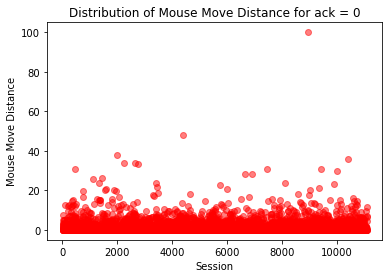

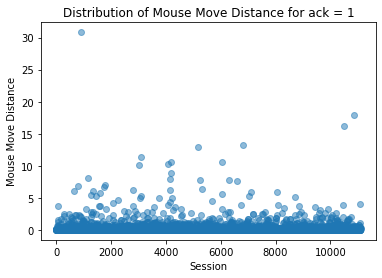

In [9]:
plt.scatter(x=ack_set.index, y=ack_set['A'], alpha=0.5, color='Red')
plt.xlabel("Session")
plt.ylabel("Mouse Move Distance")
plt.title("Distribution of Mouse Move Distance for ack = 0")
plt.show()

plt.scatter(x=no_ack_set.index, y=no_ack_set['A'], alpha=0.5)
plt.xlabel("Session")
plt.ylabel("Mouse Move Distance")
plt.title("Distribution of Mouse Move Distance for ack = 1")
plt.show()

- Z grafov už teraz vidno, že dané distribúce sú rozdielne, ale rovnako tak, že kupujúci hýbu viac myšou ako nekupujúci. To by teda nepotvrdzovalo našu hypotézu.
- Teraz môžme otestovať, či sú dané rozdelenia normálne.

In [15]:
def test_normality(df, ALPHA = 0.05):
    SHAPIRO_WILK_LIMIT = 5000
    p = -1
    
    if len(df) <= SHAPIRO_WILK_LIMIT:
        stat, p = stats.shapiro(df)
    else:
        stat, p = stats.kstest(df, 'norm')

    return p > ALPHA

def eval_dis_equality(p_val, ALPHA = 0.05):
    if p > ALPHA:
        print('Same distribution (fail to reject H0)')
        return True
    else:
        print('Different distribution (reject H0)')
        return False


In [145]:
p = -1
if test_normality(ack_set) and test_normality(no_ack_set):
    t_stat, p = stats.ttest_ind(ack_set, no_ack_set)
elif not test_normality(ack_set) and not test_normality(no_ack_set):
    t_stat, p = mannwhitneyu(ack_set, no_ack_set)

- Výslednú p hodnotu vyhodnotíme tak, že ak je väčšia aka naša alpha hodnota, tak sú rozdelenie predsalen rovnaké, a teda platí hypotéza _H0_. V opačnom prípade sa podľa mediánu oboch rozdelení zistí, ktoré rozdelenie má priemerne väčšie hodnoty.
- Pre ešte lepší prehľad o výsledku použijeme v prípade rozdielnych rozdelení aj Box Plot graf na vizualizáciu mediánu.

Different distribution (reject H0)
The median of 'pct_input' is greater for users with ack = 0 (no purchase).


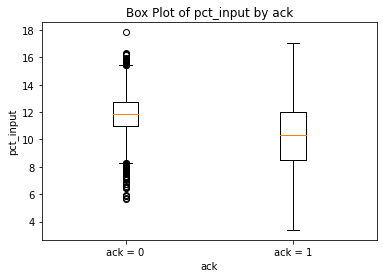

In [146]:
if not eval_dis_equality(p):

    # Compare the medians of the two groups
    median_no_ack = no_ack_set['A'].median()
    median_ack = ack_set['A'].median()
    
    if median_ack > median_no_ack:
        print(f"The median of '{TESTED_ATTR}' is greater for users with ack = 1 (item bought by user).")
    else:
        print(f"The median of '{TESTED_ATTR}' is greater for users with ack = 0 (no purchase).")
plt.boxplot([no_ack_set['A'], ack_set['A']], labels=['ack = 0', 'ack = 1'])
plt.xlabel('ack')
plt.ylabel('pct_input')
plt.title('Box Plot of pct_input by ack')
plt.show()


- Z výslednych hodnôt i grafu možno vidieť, že distribúcie sú rozdielne, takže _H1_ určite platí. Taktiež naša konkrétnejšia hypotéza bola v tomto prípade správna, nakoľko medián reprezentujúci dĺžku pohybu myši počas sedenia je predsalen väčší u nekupujúcich.

### Hypotéza 2

- V tejto časti testujeme nasledovnú hypotézu:

    _"Používatelia, ktorí si tovar kúpia, zadávajú viac vstupných dát ako tí, ktorí tovar nekúpia."_

- Hypotéza _H0_ bude teda znieť nasledovne:
  
    "_Zákazníci, ktorí si tovar kúpia, zadávajú rovnako veľa vstupných dát ako tí, ktorí si tovar nekúpia._"

- Správna alternatívna hypotéza _H1_ by pre tento prípad bola, že počet vstupných dát je v oboch prípadoch rôzny, teda jedna skupina zadáva viac dát ako druhá alebo naopak.

In [18]:
TESTED_ATTR = 'pct_input'

no_ack_set = pd.DataFrame({'A': df_sess[df_sess['ack'] == 0][TESTED_ATTR]}).dropna(how="any")
ack_set = pd.DataFrame({'A': df_sess[df_sess['ack'] == 1][TESTED_ATTR]}).dropna(how="any")

- Pre prehľadnosť si opäť zostrojíme distribučné grafy.

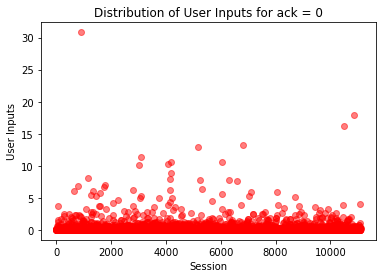

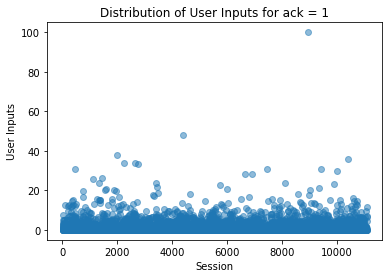

In [22]:
plt.scatter(x=no_ack_set.index, y=no_ack_set['A'], alpha=0.5, color='Red')
plt.xlabel("Session")
plt.ylabel("User Inputs")
plt.title("Distribution of User Inputs for ack = 0")
plt.show()

plt.scatter(x=ack_set.index, y=ack_set['A'], alpha=0.5)
plt.xlabel("Session")
plt.ylabel("User Inputs")
plt.title("Distribution of User Inputs for ack = 1")
plt.show()

- Z grafov možno vidieť, že distribúcie sú rôzne a že priemerne väčšie rozdelenie budú predstavovať kupujúci používatelia. Teraz to môžme ísť dokázať tak, že najskôr otestujeme, či sú rozdelenia normálne.

In [23]:
p = -1
if test_normality(ack_set) and test_normality(no_ack_set):
    t_stat, p = stats.ttest_ind(ack_set, no_ack_set)
elif not test_normality(ack_set) and not test_normality(no_ack_set):
    t_stat, p = mannwhitneyu(ack_set, no_ack_set)

how


- Test na normalitu ukázal, že rozdelenia nie sú normálne, preto na zistenie ich rovnosti vykonáme __Mann-Whitney U test__.

Different distribution (reject H0)
The median of 'pct_input' is greater for users with ack = 1 (item bought by user).


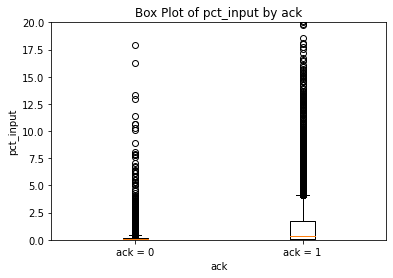

In [126]:
if not eval_dis_equality(p):

    # Compare the medians of the two groups
    median_no_ack = no_ack_set['A'].median()
    median_ack = ack_set['A'].median()
    
    if median_ack > median_no_ack:
        print(f"The median of '{TESTED_ATTR}' is greater for users with ack = 1 (item bought by user).")
    else:
        print(f"The median of '{pct_input}' is greater for users with ack = 0 (no purchase).")

    plt.boxplot([no_ack_set['A'], ack_set['A']], labels=['ack = 0', 'ack = 1'])
    plt.xlabel('ack')
    plt.ylim(0, 20)
    plt.ylabel('pct_input')
    plt.title('Box Plot of pct_input by ack')
    plt.show()